#Sentiment analysis using LSTM network
##Twitter sentiment Analysis

In [2]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available: 1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
#Loading the twitter dataset
#Note you can download the dataset from kaggle link: https://www.kaggle.com/datasets/kazanova/sentiment140

df = pd.read_csv("/content/sentiment140.csv", encoding='latin-1', header=None)
df = df[[0, 5]]
df.columns = ["label", "text"]

print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (1600000, 2)
   label                                               text
0      0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1      0  is upset that he can't update his Facebook by ...
2      0  @Kenichan I dived many times for the ball. Man...
3      0    my whole body feels itchy and like its on fire 
4      0  @nationwideclass no, it's not behaving at all....


In [5]:
def clean_text(text):
    text = re.sub(r"http\S+", "", text)          # remove URLs
    text = re.sub(r"@\w+", "", text)           # remove mentions
    text = re.sub(r"[^a-zA-Z\s]", "", text)      # keep letters only
    text = text.lower().strip()
    return text

df["text"] = df["text"].apply(clean_text)

In [6]:
df["text"].shape

(1600000,)

In [7]:
# 3. Tokenization & Padding

max_words = 20000   # vocab size
max_len = 100       # max tweet length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df["text"])

X = tokenizer.texts_to_sequences(df["text"])
X = pad_sequences(X, maxlen=max_len)

y = df["label"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (1280000, 100)
Testing data shape: (320000, 100)


In [9]:
print(np.unique(y_train)[:20])  # show unique labels
print("Shape:", y_train.shape)

[0 4]
Shape: (1280000,)


In [10]:
# 4. Build LSTM Model
from tensorflow.keras import Input

#Optimised forfast training using colab's T4
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

from tensorflow.keras.optimizers import Adam

num_classes = 5  # since labels are [0,1,2,3,4]

model = Sequential()
model.add(Input(shape=(max_len,)))
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_len))
model.add(LSTM(128, dropout=0.2))
model.add(Dense(num_classes, activation="softmax", dtype="float32"))  # softmax for multi-class

optimizer = Adam(learning_rate=1e-3, clipnorm=1.0)  # gradient clipping for RNN stability
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

print(model.summary())


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,692,229 (10.27 MB)

 Trainable params: 2,692,229 (10.27 MB)

 Non-trainable params: 0 (0.00 B)

None


In [11]:
# Use tf.data for efficiency
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(128).prefetch(tf.data.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(128).prefetch(tf.data.AUTOTUNE)

history = model.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 141s 13ms/step - accuracy: 0.7808 - loss: 0.4572 - val_accuracy: 0.8206 - val_loss: 0.3925
Epoch 2/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 133s 13ms/step - accuracy: 0.8273 - loss: 0.3813 - val_accuracy: 0.8256 - val_loss: 0.3850
Epoch 3/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 134s 13ms/step - accuracy: 0.8388 - loss: 0.3599 - val_accuracy: 0.8259 - val_loss: 0.3880
Epoch 4/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 123s 12ms/step - accuracy: 0.8489 - loss: 0.3412 - val_accuracy: 0.8240 - val_loss: 0.3994
Epoch 5/5
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 124s 12ms/step - accuracy: 0.8583 - loss: 0.3238 - val_accuracy: 0.8215 - val_loss: 0.4182


In [12]:
# 6. Evaluate

loss, acc = model.evaluate(X_test, y_test, batch_size=64)
print("Test Loss:", loss)
print("Test Accuracy:", acc)

5000/5000 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.8213 - loss: 0.4171
Test Loss: 0.41817596554756165
Test Accuracy: 0.8215062618255615


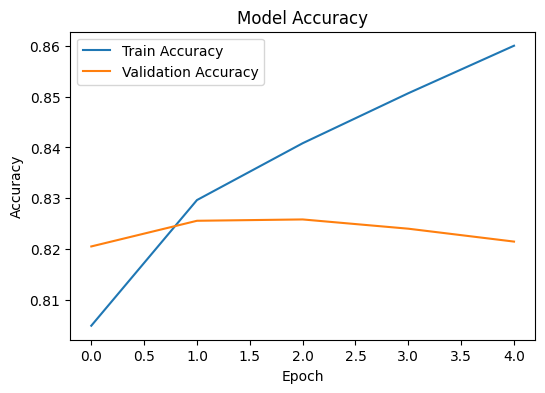

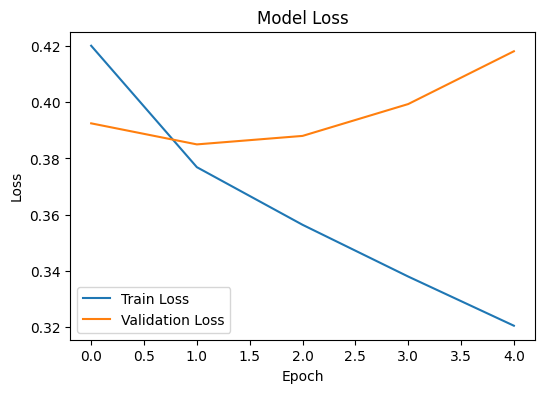

In [13]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


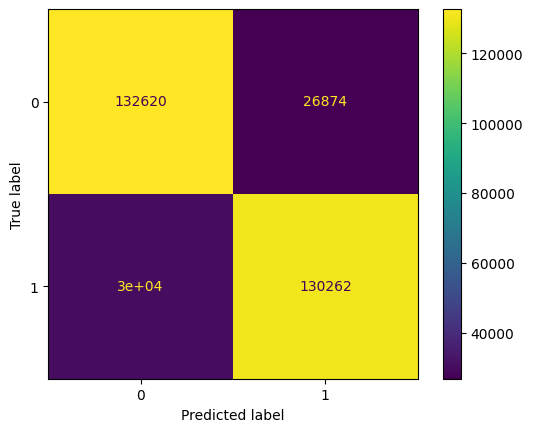

In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# y_pred from model.predict() → convert to class indices
y_pred_classes = np.argmax(y_pred, axis=1)  # pick class with highest probability

# Now compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [26]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Map class indices to sentiment labels
class_mapping = {
    0: "Very Negative",
    1: "Negative",
    2: "Neutral",
    3: "Positive",
    4: "Very Positive"
}


def predict_sentiment(text):
    # 1️⃣ Clean the tweet
    text = clean_text(text)

    # 2️⃣ Convert to sequence
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=max_len)

    # 3️⃣ Predict probabilities for all classes
    pred_probs = model.predict(padded)[0]  # shape = (num_classes,)

    # 4️⃣ Pick the class with highest probability
    pred_class = np.argmax(pred_probs)
    confidence = pred_probs[pred_class]

    # 5️⃣ Print result
    print(f"Tweet: {text}")
    print(f"Sentiment: {class_mapping[pred_class]}  (confidence: {confidence:.2f})")


In [27]:
predict_sentiment("I love this movie, it was amazing!")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tweet: i love this movie it was amazing
Sentiment: Very Positive  (confidence: 1.00)


In [29]:
predict_sentiment("This product is terrible, waste of money...")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tweet: this product is terrible waste of money
Sentiment: Very Negative  (confidence: 0.94)
